Binary Classification with a Software Defects Dataset
Playground Series - Season 3, Episode 23

288 from 1702 Liderbord position.



This laptop skips calculations of individual cells, which require a long time, and immediately inserts the results obtained from calculations using other resources.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.base import clone

from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate


from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.utils import class_weight

import itertools

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC, NuSVC, SVC
from xgboost import XGBClassifier
from datetime import datetime

In [2]:
# Описываем пользовательские функции

# Функция для вывода confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues): 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes) 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Функция принимает фактическое и прогнозное значения и выводит ряд метрик качества модели
# можно указать порог, по умолчанию он равен 0.5
def metrics(fact, pred, trash=0.5):
    plot_confusion_matrix(confusion_matrix(fact, pred > trash), ['0','1'])
    print('precision:', precision_score(fact, pred > trash))
    print('recall:', recall_score(fact, pred > trash))
    print('f1_score:', f1_score(fact, pred > trash))    
    print('accuracy_score:', accuracy_score(fact, pred > trash))
    print('roc_auc:', roc_auc_score(fact, pred))

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e23/train.csv', index_col='id')
print(train.shape)
train.head()

(101763, 22)


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [4]:
# Проверим наличие пропусков

# Если пропуски есть - визуализируем их распределение по признакам
# красный - пропущенные данные, серый - ок


# Расчет количества и доли пропусков
miss = train.isna().sum().sum()
print('Missing Values:', miss)

if miss > 0:
    
    plt.figure(figsize=(10,6))
    sns.heatmap(train.isnull(), cmap=sns.color_palette(['#c0c0c0', '#ff0000']))
    
    for col in train.columns:
        miss = train[col].isna().sum()
        if miss > 0:
            print(f'В столбце {col} пропущенных значений {miss}. Доля пропусков {(miss/train.shape[0]*100):5.2f}%')

# Проверка наличия дубликатов в данных
print('Duplicates in Data:', train.duplicated().sum())

Missing Values: 0
Duplicates in Data: 0


In [5]:
# Оценим баланс классов
train.defects.sum() / len(train)

0.22664426166681406

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
loc,101763.0,37.347160,54.600401,1.0,13.00,22.00,42.00,3442.00
v(g),101763.0,5.492684,7.900855,1.0,2.00,3.00,6.00,404.00
ev(g),101763.0,2.845022,4.631262,1.0,1.00,1.00,3.00,165.00
iv(g),101763.0,3.498826,5.534541,1.0,1.00,2.00,4.00,402.00
n,101763.0,96.655995,171.147191,0.0,25.00,51.00,111.00,8441.00
v,101763.0,538.280956,1270.791601,0.0,97.67,232.79,560.25,80843.08
l,101763.0,0.111634,0.100096,0.0,0.05,0.09,0.15,1.00
d,101763.0,13.681881,14.121306,0.0,5.60,9.82,18.00,418.20
i,101763.0,27.573007,22.856742,0.0,15.56,23.36,34.34,569.78
e,101763.0,20853.589876,190571.405427,0.0,564.73,2256.23,10193.24,16846621.12


In [7]:
x = train.drop('defects', axis=1)
y = train.defects

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42, stratify=y)

cw = list(class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train), 
                                            y=y_train
                                           )
         )

In [ ]:
classifiers = {}
classifiers['AdaBoostClassifier'] = [AdaBoostClassifier()]
classifiers['BaggingClassifier'] = [BaggingClassifier(n_jobs=7)]
classifiers['ExtraTreesClassifier'] = [ExtraTreesClassifier(n_jobs=7, class_weight='balanced')]
classifiers['GradientBoostingClassifier'] = [GradientBoostingClassifier()]
classifiers['RandomForestClassifier'] = [RandomForestClassifier(n_jobs=7, class_weight='balanced')]
classifiers['MLPClassifier'] = [MLPClassifier()]
classifiers['SGDClassifier'] =[SGDClassifier(loss='log_loss', n_jobs=7, class_weight='balanced')]
classifiers['XGBClassifier'] = [XGBClassifier(n_jobs=7)]
classifiers['LogisticRegression'] = [LogisticRegression(n_jobs=7, class_weight='balanced')]
classifiers['CatBoostClassifier'] = [CatBoostClassifier(class_weights=cw)]

print('Start Modeling', datetime.now().strftime("%H:%M:%S"))

for cl in classifiers.keys():
    cv_score = cross_val_score(classifiers[cl][0],
                               x_train,
                               y_train,
                               n_jobs=-1,
                               cv=3, 
                               scoring="roc_auc", 
                               verbose=False
                              )
    classifiers[cl].append(cv_score)    
    print(datetime.now().strftime("%H:%M:%S"), cl, cv_score)

In [ ]:
# Start Modeling 15:08:03
# 15:08:10 AdaBoostClassifier [0.78135272 0.79060676 0.78926545]
# 15:08:15 BaggingClassifier [0.72544969 0.73452284 0.7243994 ]
# 15:08:23 ExtraTreesClassifier [0.75686163 0.76184484 0.75887452]
# 15:08:36 GradientBoostingClassifier [0.78387    0.79270193 0.79131214]
# 15:08:44 RandomForestClassifier [0.76290092 0.76857797 0.76641018]
# 15:08:49 MLPClassifier [0.43651013 0.61608849 0.73465876]
# 15:08:50 SGDClassifier [0.67384868 0.59472121 0.34652268]
# 15:08:54 XGBClassifier [0.77230609 0.77953251 0.7794976 ]
# 15:08:55 LogisticRegression [0.73840332 0.75082846 0.75091384]
# 15:09:23 CatBoostClassifier [0.77845047 0.78855293 0.78799572]

## CatBoostClassifier

precision: 0.4749455337690632
recall: 0.6616563087151323
f1_score: 0.5529653339775336
accuracy_score: 0.7575420092371188
roc_auc: 0.7895526770442683
CPU times: user 1min 2s, sys: 4.1 s, total: 1min 6s
Wall time: 17.6 s


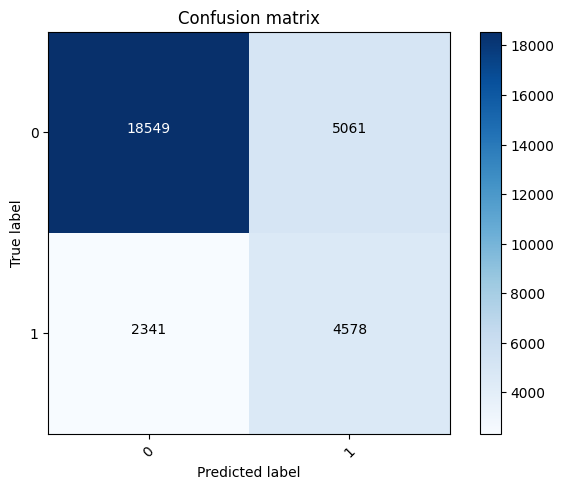

In [10]:
%%time

cb = CatBoostClassifier(class_weights=cw)



cb.fit(x_train, y_train, verbose = False)

test_pred = cb.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

In [ ]:
%%time

def objective(trial):    
    params = {
        
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 15),
        'subsample': trial.suggest_float('subsample', 0.3, 0.95),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'verbose': False
    }
    
    
    cbc = CatBoostClassifier(**params,
                             class_weights=cw,
#                              task_type="GPU"
                            )
    
    return cross_val_score(cbc,
                           x_train,
                           y_train,
                           n_jobs=-1,
                           cv=3, 
                           scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2000)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
roc_auc: 0.7909276396488938
Best hyperparameters: {'depth': 5, 'l2_leaf_reg': 97.96341503720109, 'boosting_type': 'Plain', 'iterations': 809, 'min_data_in_leaf': 5, 'subsample': 0.31464410658791775, 'learning_rate': 0.020114534345879145, 'random_strength': 0.06025025168848249, 'bagging_temperature': 4.096407962455776, 'od_type': 'IncToDec', 'od_wait': 31}
Wall time: 1d 2h 36min 29s

precision: 0.47626725788572005
recall: 0.683046683046683
f1_score: 0.5612160076000474
accuracy_score: 0.757935078122441
roc_auc: 0.8012904695765897


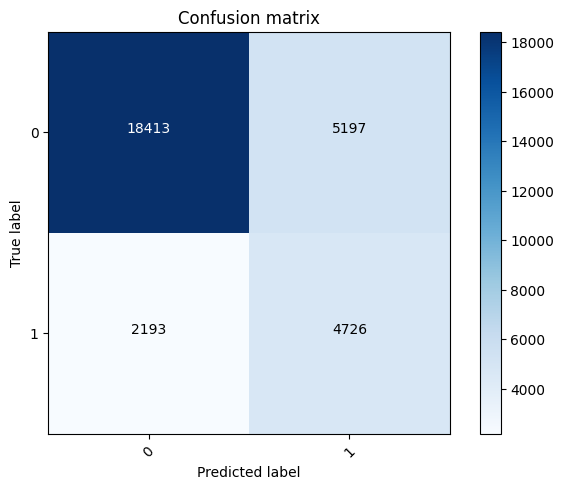

In [11]:
# Обучаем модель с лучшими параметрами на всем датасете

best_cb_param = {'depth': 5,
                 'l2_leaf_reg': 97.96341503720109,
                 'boosting_type': 'Plain',
                 'iterations': 809,
                 'min_data_in_leaf': 5,
                 'subsample': 0.31464410658791775,
                 'learning_rate': 0.020114534345879145,
                 'random_strength': 0.06025025168848249,
                 'bagging_temperature': 4.096407962455776,
                 'od_type': 'IncToDec',
                 'od_wait': 31
                }

cat_grid_model = CatBoostClassifier(**best_cb_param,
                                    class_weights=cw,
                                   )

cat_grid_model.fit(x,
                   y,
                   verbose = False
                  )

test_pred = cat_grid_model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

In [ ]:
# строим прогноз на тестовых данных и сохраняем в файл sample_submission

test = pd.read_csv('test.csv')
test['defects'] = cat_grid_model.predict_proba(test)[:,1]
test[['id', 'defects']].to_csv('sample_submission_cb.csv', index=False)

## RandomForestClassifier

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': ['balanced'],
               'criterion': ['entropy', 'log_loss', 'gini']
              }

model = RandomForestClassifier()

rs = RandomizedSearchCV(model,
                        param_dist,
                        n_iter = 200,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        scoring="roc_auc",
                        random_state=0)
rs.fit(x_train, y_train)
rs.best_params_

In [ ]:
Wall time: 40min 43s
{'n_estimators': 1000,
 'min_samples_split': 44,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 9,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': True}

In [13]:
rf_best_param = {'n_estimators': 1000,
 'min_samples_split': 44,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 9,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': True}

precision: 0.49044322760615766
recall: 0.6860818037288625
f1_score: 0.5719966260995301
accuracy_score: 0.7673032198892856
roc_auc: 0.808943857460189


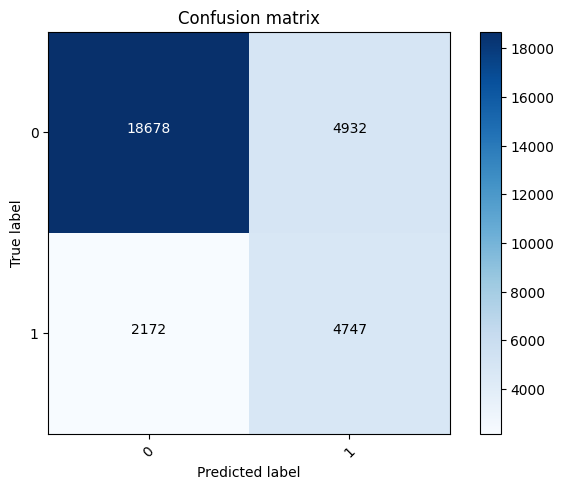

In [14]:
# Обучаем модель с лучшими параметрами на всем датасете

rf = RandomForestClassifier(**rf_best_param, n_jobs=-1)
rf.fit(x, y)

test_pred = rf.predict_proba(x_test)[:,1]

metrics(y_test, test_pred)

In [ ]:
test = pd.read_csv('test.csv')
test['defects'] = rf.predict_proba(test.drop('id', axis=1))[:,1]
test[['id', 'defects']].to_csv('sample_submission_rf.csv', index=False)

## GradientBoostingClassifier

In [ ]:
%%time

def objective(trial):
    loss = trial.suggest_categorical('loss', ['log_loss', 'exponential'])
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    n_estimators = trial.suggest_int('n_estimators', 50, 750)
#     learning_rate = trial.suggest_float ('learning_rate', 0.001, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 12)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 12)
#     min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
    max_depth = trial.suggest_int('max_depth', 2, 15)
#     warm_start = trial.suggest_int('warm_start', 0, 1)
#     ccp_alpha = trial.suggest_float ('ccp_alpha', 0.0, 10)   
    
    
    
    gbc = GradientBoostingClassifier(loss=loss,
                                     criterion=criterion,
                                     n_estimators=n_estimators,
#                                      learning_rate = learning_rate,
                                     min_samples_split=min_samples_split,                                     
                                     min_samples_leaf = min_samples_leaf,
#                                      min_weight_fraction_leaf = min_weight_fraction_leaf,
                                     max_depth = max_depth,
#                                      warm_start = warm_start,
#                                      ccp_alpha = ccp_alpha
                                    )
    
    return cross_val_score(gbc,
                           x_train,
                           y_train,
                           n_jobs=-1,
                           cv=3, 
                           scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

precision: 0.6582829504232165
recall: 0.3934094522329816
f1_score: 0.4924914058259453
accuracy_score: 0.8162402961118936
roc_auc: 0.798464019945446
CPU times: user 1min 2s, sys: 129 ms, total: 1min 2s
Wall time: 1min 2s


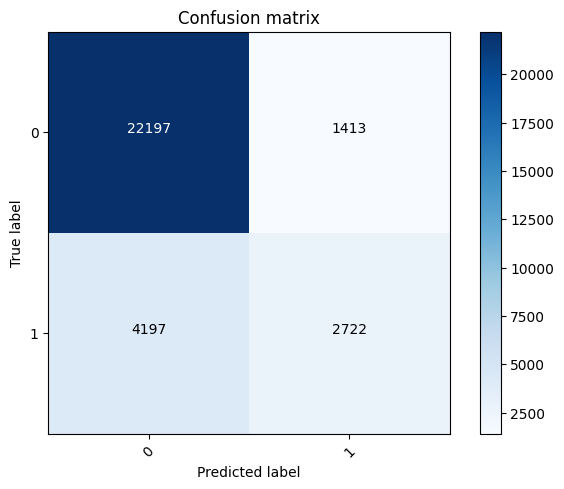

In [15]:
%%time

# обучим модель с лучшими параметраи на всем датасете


best_gb_param = {'loss': 'exponential',
                 'criterion': 'squared_error',
                 'n_estimators': 305,
                 'min_samples_split': 8,
                 'min_samples_leaf': 8,
                 'max_depth': 2
                }

gbc = GradientBoostingClassifier(**best_gb_param)

gbc.fit(x, y)
test_pred = gbc.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

In [ ]:
test = pd.read_csv('test.csv')
test['defects'] = gbc.predict_proba(test.drop('id', axis=1))[:,1]
test[['id', 'defects']].to_csv('sample_submission_gbc.csv', index=False)

## AdaBoostClassifier

In [ ]:
%%time

def objective(trial):    
    param = {'n_estimators': trial.suggest_int("n_estimators", 50, 2000),
             'learning_rate': trial.suggest_float("learning_rate", 0.001, 1.0, log=True),
             'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
            }


        
    adb = AdaBoostClassifier(**param, random_state=42)

    return cross_val_score(adb,
                           x_train, 
                           y_train,
                           n_jobs=-1,
                           cv=4, 
                           scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Best result finished with value: 0.7893944394786825 and parameters: {'n_estimators': 1890, 'learning_rate': 0.08752018796993234, 'algorithm': 'SAMME.R'}. Best is trial 31 with value: 0.7893944394786825.

Compared to other models, this is a bad result, I will no longer work with this model.

## LogisticRegression

With the default parameters and without processing the features, a terrible result was obtained:


LogisticRegression [0.73840332 0.75082846 0.75091384]

But this class of models is sensitive to the distribution and scaling of variables.

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


precision: 0.45829717481438625
recall: 0.6869489810666282
f1_score: 0.5497975708502024
accuracy_score: 0.745029316387697
roc_auc: 0.7889716480268839


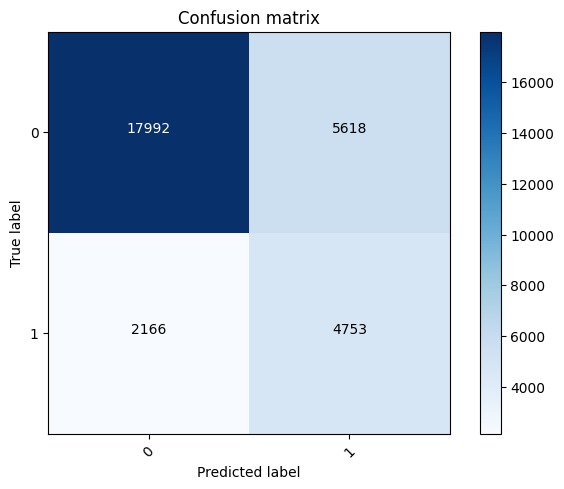

In [21]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)

x_train_log = pd.DataFrame(transformer.transform(x_train), columns=x_train.columns)
x_test_log = pd.DataFrame(transformer.transform(x_test), columns=x_test.columns)

lr_model = LogisticRegression(n_jobs=7, class_weight='balanced')
lr_model.fit(x_train_log, y_train)

test_pred = lr_model.predict_proba(x_test_log)[:,1]
metrics(y_test, test_pred)

The result has improved significantly. Let's increase the max_iter parameter to get rid of the warning: "ITERATIONS REACHED LIMIT"

precision: 0.4573176560558264
recall: 0.6914293973117502
f1_score: 0.5505178365937858
accuracy_score: 0.7441121556552786
roc_auc: 0.789779605587962


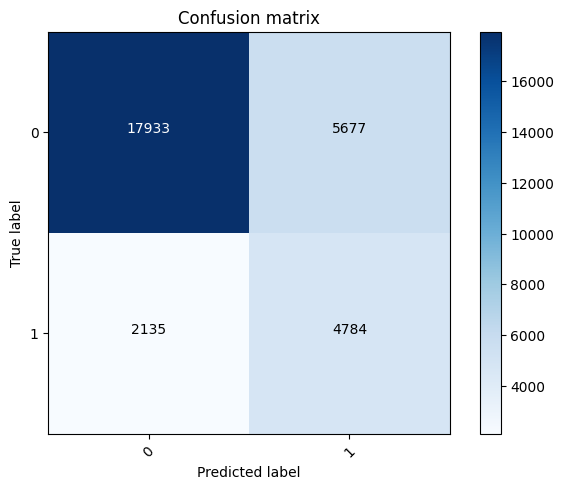

In [22]:
lr_model = LogisticRegression(n_jobs=7, class_weight='balanced', max_iter=500)
lr_model.fit(x_train_log, y_train)

test_pred = lr_model.predict_proba(x_test_log)[:,1]
metrics(y_test, test_pred)

precision: 0.4899638038828562
recall: 0.6456135279664691
f1_score: 0.5571214766774756
accuracy_score: 0.7673687313701726
roc_auc: 0.7848552583323493


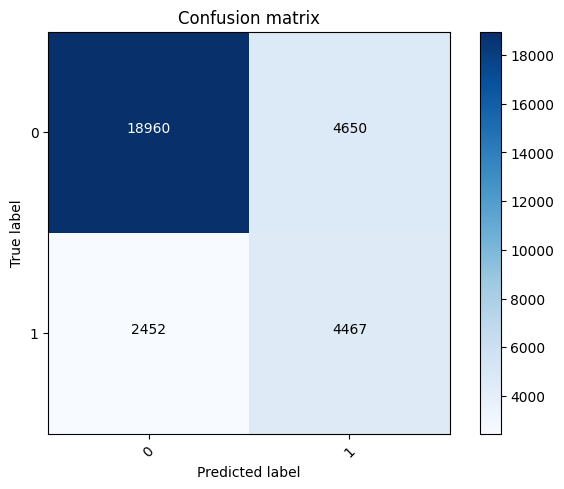

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

lr_model = LogisticRegression(n_jobs=7, class_weight='balanced', max_iter=500)
lr_model.fit(x_train_scaled, y_train)

test_pred = lr_model.predict_proba(x_test_scaled)[:,1]
metrics(y_test, test_pred)

precision: 0.457033857892227
recall: 0.6925856337621044
f1_score: 0.5506780050563089
accuracy_score: 0.7438501097317305
roc_auc: 0.789756980376608


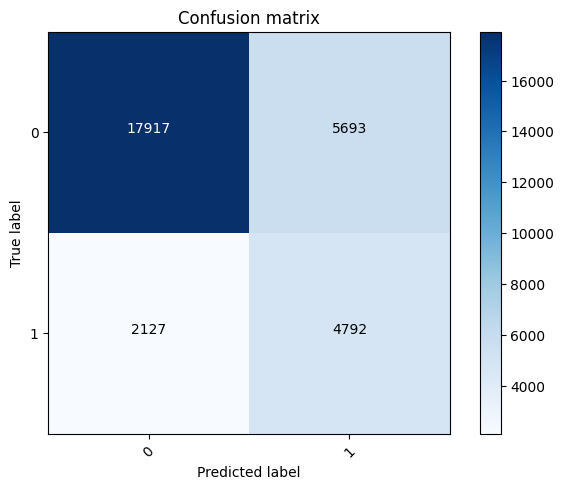

In [26]:
scaler_log = StandardScaler().fit(x_train_log)
x_train_scaled_log = pd.DataFrame(scaler_log.transform(x_train_log), columns=x_train.columns)
x_test_scaled_log = pd.DataFrame(scaler_log.transform(x_test_log), columns=x_test.columns)

lr_model = LogisticRegression(n_jobs=7, class_weight='balanced', max_iter=500)
lr_model.fit(x_train_scaled_log, y_train)

test_pred = lr_model.predict_proba(x_test_scaled_log)[:,1]
metrics(y_test, test_pred)

In [ ]:
%%time

def objective(trial):    
    param = {
        "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]),
        "max_iter": trial.suggest_int('max_iter', 70, 5000),        
        "tol" : trial.suggest_float('tol' , 1e-6 , 1e-3),
        "C": trial.suggest_float('C', 1e-10, 1000, log=True)

    }


        
    lr_model = LogisticRegression(**param, class_weight='balanced')

    return cross_val_score(lr_model,
                           x_train_scaled_log, 
                           y_train,
                           n_jobs=-1,
                           cv=4, 
                           scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

precision: 0.4570446735395189
recall: 0.6920075155369273
f1_score: 0.5505030181086519
accuracy_score: 0.743882865472174
roc_auc: 0.7897722842262793
CPU times: user 4.69 s, sys: 2.53 s, total: 7.22 s
Wall time: 1.93 s


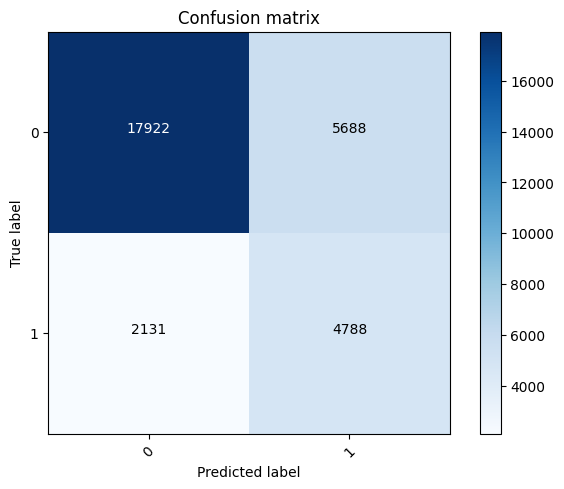

In [30]:
%%time

best_lr_hyperparameters = {'solver': 'lbfgs', 
                           'max_iter': 422, 
                           'tol': 0.000729722445321157, 
                           'C': 0.4813894097529452
                          }
lr_Pipeline = make_pipeline(transformer, 
                            scaler_log, 
                            LogisticRegression(**best_lr_hyperparameters, class_weight='balanced'))

lr_Pipeline.fit(x_train, y_train)
test_pred = lr_Pipeline.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

## HistGradientBoostingClassifier

In [ ]:
%%time

def objective(trial):    
    params = {'max_iter': trial.suggest_int('max_iter', 50, 1000),
              'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 200),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 15, 100),
              'max_depth': trial.suggest_int('max_depth', 2, 50),
#               'max_bins': trial.suggest_int('max_bins', 100, 500),
              'warm_start': trial.suggest_int('warm_start', 0, 1),
#               'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
              'l2_regularization': trial.suggest_float('l2_regularization', 0, 0.15),
             }
    
    
    hgb = HistGradientBoostingClassifier(**params)
    
    return cross_val_score(hgb,
                           x_train,
                           y_train,
                           n_jobs=-1,
                           cv=3, 
                           scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

precision: 0.6507628965851295
recall: 0.3883509177626825
f1_score: 0.4864228819695873
accuracy_score: 0.8141439287235088
roc_auc: 0.7936581673370672


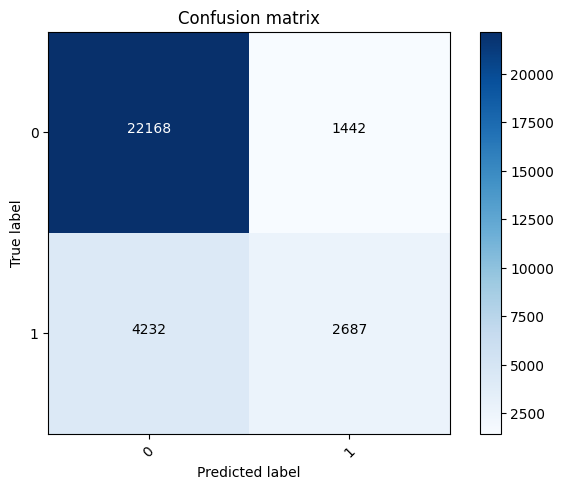

In [31]:
best_hgb_hyperparameters = {'max_iter': 451,
                            'max_leaf_nodes': 40,
                            'min_samples_leaf': 41,
                            'max_depth': 2,
                            'warm_start': 1,
                            'l2_regularization': 0.09936832313532057
                           }
    
hgb = HistGradientBoostingClassifier(**best_hgb_hyperparameters)
hgb.fit(x_train, y_train)

test_pred = hgb.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

## VotingClassifier

In [33]:
best_cb_param = {'iterations': 504, 'learning_rate': 0.026432342169309744, 'depth': 5, 'l2_leaf_reg': 1.2650491322464137}


best_hgb_hyperparameters = {'max_iter': 451,
                            'max_leaf_nodes': 40,
                            'min_samples_leaf': 41,
                            'max_depth': 2,
                            'warm_start': 1,
                            'l2_regularization': 0.09936832313532057
                           }


best_gb_param = {'loss': 'exponential',
                 'criterion': 'squared_error',
                 'n_estimators': 305,
                 'min_samples_split': 8,
                 'min_samples_leaf': 8,
                 'max_depth': 2
                }

best_rf_param = {'n_estimators': 1000,
 'min_samples_split': 44,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 9,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': True}

0:	learn: 0.6859061	total: 20ms	remaining: 10.1s
1:	learn: 0.6790919	total: 36.4ms	remaining: 9.14s
2:	learn: 0.6724804	total: 53.3ms	remaining: 8.89s
3:	learn: 0.6662511	total: 68.5ms	remaining: 8.57s
4:	learn: 0.6601934	total: 84.1ms	remaining: 8.39s
5:	learn: 0.6548437	total: 98ms	remaining: 8.13s
6:	learn: 0.6497141	total: 114ms	remaining: 8.08s
7:	learn: 0.6447733	total: 130ms	remaining: 8.04s
8:	learn: 0.6402592	total: 145ms	remaining: 7.98s
9:	learn: 0.6359486	total: 161ms	remaining: 7.94s
10:	learn: 0.6320346	total: 177ms	remaining: 7.94s
11:	learn: 0.6284371	total: 193ms	remaining: 7.93s
12:	learn: 0.6248789	total: 208ms	remaining: 7.87s
13:	learn: 0.6212169	total: 225ms	remaining: 7.88s
14:	learn: 0.6178024	total: 242ms	remaining: 7.89s
15:	learn: 0.6144335	total: 258ms	remaining: 7.86s
16:	learn: 0.6112763	total: 273ms	remaining: 7.83s
17:	learn: 0.6086667	total: 288ms	remaining: 7.78s
18:	learn: 0.6060558	total: 304ms	remaining: 7.76s
19:	learn: 0.6034421	total: 319ms	remai

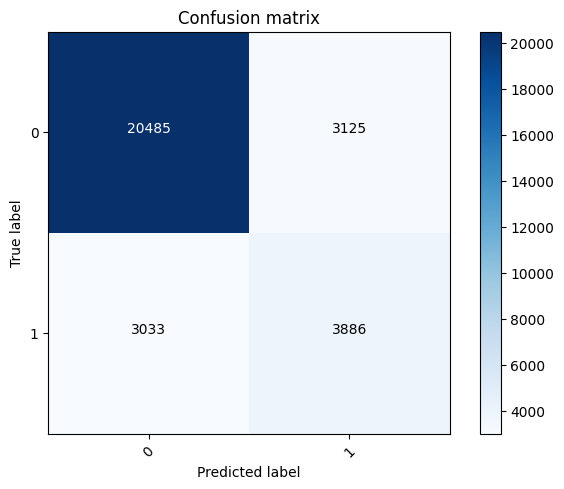

In [35]:
%%time

ensemble = VotingClassifier(
    [('cb', CatBoostClassifier(**best_cb_param, class_weights=cw)),
     ('hgb', HistGradientBoostingClassifier(**best_hgb_hyperparameters)),
     ('rf', RandomForestClassifier(**best_rf_param)),
     ('gbc', GradientBoostingClassifier(**best_gb_param)),
     ('lr', lr_Pipeline)
    ],
    voting='soft',
    weights=[0.2, 0.2, 0.2, 0.2, 0.2])

ensemble.fit(x_train, y_train)

test_pred = ensemble.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

In [ ]:
test = pd.read_csv('test.csv')
test['defects']  = ensemble.predict_proba(test.drop('id', axis=1))[:,1]
test[['id', 'defects']].to_csv('sample_submission_ensemble.csv', index=False)